In [1]:
# --- Standard libraries
import os.path as osp
import pandas as pd
import numpy as np
import pickle as pkl
# --- Matplotlib
import matplotlib.pyplot as plt
import imageio
# --- PyTorch and PyG
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import degree
# --- XASNet
from XASNet.data import QM9_XAS
from XASNet.data import save_split
from XASNet.models import XASNet_GNN, XASNet_GAT, XASNet_GraphNet, XASNet_NNconv, XASNet_PNA
from XASNet.trainer import GNNTrainer

In [2]:
# --- Load in the dataset
root = './datasets/mol_short_dataset.pt'
go_spec = QM9_XAS(root=root,
                  raw_dir='./datasets/',
                  spectra=[])

In [3]:
# --- Print details of the dataset
print(go_spec)
print('------------')
print(f'Number of graphs: {len(go_spec)}')
print(f'Number of features: {go_spec.num_features}')
print('')

# --- Print details of the first molecule/graph in dataset
data = go_spec[0]

print(data)
print('------------')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

QM9_XAS(317)
------------
Number of graphs: 317
Number of features: 5

Data(x=[32, 5], edge_index=[2, 76], edge_attr=[76, 3], spectrum=[200], pos=[32, 3], z=[32], idx=[1], smiles='c12[c:2]3[cH:1][cH:25][c:24]4[c:22]1[c:17]1[c:19]([cH:20][cH:23]4)[C:18]([C:21](=[O:26])[OH:27])=[CH:16][C:15]4=[CH:14][CH:12]=[C:11]5[C:9]([OH:30])([CH:4]2[C:6]([OH:31])([C:5]([C:8](=[O:28])[OH:29])=[CH:3]3)[CH:7]=[CH:10]5)[CH:13]41')
------------
Number of nodes: 32
Number of edges: 76
Average node degree: 2.38
Has isolated nodes: False
Has self loops: False
Is undirected: True


In [4]:
# --- Create spilt file with the dataset
# --- split into test, validation and test datasets
idxs = save_split(
    path='./datasets/xasnet-mol-split.npz',
    ndata=len(go_spec),
    ntrain=238,
    nval=29,
    ntest=48,
    save_split=True,
    shuffle=True, 
    print_nsample=True
)

In [5]:
# --- Create variables for each dataset split
train_go = [go_spec[i] for i in idxs['train']]
val_go = [go_spec[i] for i in idxs['val']]
test_go = [go_spec[i] for i in idxs['test']]

# --- Save datasets splits into dataloaders
train_loader = DataLoader(train_go, batch_size=238, shuffle=True)
val_loader = DataLoader(val_go, batch_size=29, shuffle=True)
test_loader = DataLoader(test_go, batch_size=48, shuffle=False)

print(f'Training dataset length: {len(train_go)}, compiled in {len(train_loader)} loaders')
print(f'Validation dataset length: {len(val_go)}, compiled in {len(val_loader)} loaders')
print(f'Test dataset length: {len(test_go)}, compiled in {len(test_loader)} loaders')

Training dataset length: 238, compiled in 1 loaders
Validation dataset length: 29, compiled in 1 loaders
Test dataset length: 48, compiled in 1 loaders


In [6]:
# --- Save the dataloader to a file
torch.save(test_go, './datasets/mol_test_dataset.pt')

In [7]:
# --- Define cost functions
def RSE_loss(prediction, target):
    dE = (300 - 280) / 200
    nom = torch.sum(dE*torch.pow((target-prediction), 2))
    denom = torch.sum(dE*target)
    return torch.sqrt(nom) / denom 

def RMSE_loss(prediction, target):
    return torch.sqrt(torch.mean((target - prediction)**2))

def MSE_loss(prediction, target):
    return torch.mean((target - prediction)**2)

In [8]:
# --- Set number of epochs to run
num_epochs = 300
# --- Set the learning rate 
lr = 0.001
# --- Milestones to reduce learning rate in steps 
milestones = np.arange(100, 900, 200).tolist()
print(milestones)

[100, 300, 500, 700]


In [9]:
max_degree = -1
for data in train_go:
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    max_degree = max(max_degree, int(d.max()))

deg = torch.zeros(max_degree + 1, dtype=torch.long)
for data in train_go:
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    deg += torch.bincount(d, minlength=deg.numel())

In [10]:
model_name = 'xasnet_pna_model'

device = 'cuda' if torch.cuda.is_available() else 'cpu'

xasnet_pna = XASNet_PNA(
    num_targets = 200,
    deg = deg
).to(device)

path_to_model = osp.join('./best_model', model_name)

if osp.exists(path_to_model):
    xasnet_nnconv.load_state_dict(torch.load(path_to_model))
else:
    print('Model is not loaded')

Model is not loaded


In [11]:
print(xasnet_pna)

XASNet_PNA(
  (conv1): PNAConv(5, 64, towers=1, edge_dim=3)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): PNAConv(64, 128, towers=1, edge_dim=3)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): PNAConv(128, 256, towers=1, edge_dim=3)
  (batchnorm3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mlp): Linear(in_features=256, out_features=200, bias=True)
)


##### XASNet GNN

In [12]:
# --- Set name for ML model
model_name = 'xasnet_gnn_model'

# --- Set device for model to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Create the type of ML model you want to run
xasnet_gnn = XASNet_GNN(
    gnn_name = 'gcn', # model type
    in_channels = [15, 64, 128, 256], # input nodes for each layer
    out_channels = [64, 128, 256, 512], # output nodes for each layer
    num_targets = 200, # nodes for final output
    num_layers = 4, # number of total layers
    heads = 0
).to(device)

# --- Location to save model
path_to_model = osp.join('./best_model,', model_name)

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_gnn.load_state_dict(torch.load(path_to_model))
else:
    print('Model is not loaded.')

Model is not loaded.


In [13]:
# --- View the details of the created model
print(xasnet_gnn)
print('----')
print(f' Model will be trained on: {device}')

XASNet_GNN(
  (batch_norms): ModuleList(
    (0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (interaction_layers): ModuleList(
    (0): GCNConv(15, 64)
    (1): GCNConv(64, 128)
    (2): GCNConv(128, 256)
    (3): GCNConv(256, 512)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=512, out_features=200, bias=True)
)
----
 Model will be trained on: cpu


##### XASNet GAT

In [14]:
# --- Set name for ML model
model_name = 'xasnet_gat_model'

# --- Set device for model to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Create the type of ML model you want to run
xasnet_gat = XASNet_GAT(
    node_features_dim=15,
    in_channels=[128, 128, 128, 128],
    out_channels=[128, 128, 128, 400],
    targets=200,
    n_layers=4,
    n_heads=3,
    gat_type='gatv2_custom',
    use_residuals=True,
    use_jk=True
).to(device)

# --- Location to save model
path_to_model = osp.join('./best_model,', model_name)

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_gat.load_state_dict(torch.load(path_to_model))
else:
    print('Model is not loaded.')

Model is not loaded.


In [15]:
# --- View the details of the created model
print(xasnet_gat)
print('----')
print(f' Model will be trained on: {device}')

XASNet_GAT(
  (pre_layer): LinearLayer(
    (linear): Linear(in_features=15, out_features=128, bias=False)
    (_activation): ReLU(inplace=True)
  )
  (res_block): Residual_block(
    (res_layers): Sequential(
      (0): LinearLayer(
        (linear): Linear(in_features=128, out_features=128, bias=False)
        (_activation): ReLU(inplace=True)
      )
      (1): LinearLayer(
        (linear): Linear(in_features=128, out_features=128, bias=False)
        (_activation): ReLU(inplace=True)
      )
      (2): LinearLayer(
        (linear): Linear(in_features=128, out_features=128, bias=False)
        (_activation): ReLU(inplace=True)
      )
      (3): LinearLayer(
        (linear): Linear(in_features=128, out_features=128, bias=False)
        (_activation): ReLU(inplace=True)
      )
    )
  )
  (gat_layers): ModuleList(
    (0): GATv2LayerCus(128, 128)
    (1): ReLU(inplace=True)
    (2): GATv2LayerCus(384, 128)
    (3): ReLU(inplace=True)
    (4): GATv2LayerCus(384, 128)
    (5): ReLU

##### XASNet GraphNet

In [16]:
# --- Set name for ML model
model_name = 'xasnet_graphnet_model'

# --- Set device for model to run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Create the type of ML model you want to run
xasnet_graphnet = XASNet_GraphNet(
    node_dim=15,
    edge_dim=6,
    hidden_channels=512,
    out_channels=200,
    gat_hidd=512,
    gat_out=200,
    n_layers=3,
    n_targets=200
).to(device)

# --- Location to save model
path_to_model = osp.join('./best_model,', model_name)

# --- Check if there is an already existing model
if osp.exists(path_to_model):
    xasnet_graphnet.load_state_dict(torch.load(path_to_model))
else:
    print('Model is not loaded.')

Model is not loaded.


In [17]:
# --- View the details of the created model
print(xasnet_graphnet)
print('----')
print(f' Model will be trained on: {device}')

XASNet_GraphNet(
  (graphnets): ModuleList(
    (0): GraphNetwork(
      (gatencoder): GATEncoder(
        (gats): ModuleList(
          (0): GATv2Conv(15, 512, heads=3)
          (1): ReLU(inplace=True)
          (2): GATv2Conv(1536, 512, heads=3)
          (3): ReLU(inplace=True)
          (4): GATv2Conv(1536, 512, heads=3)
          (5): ReLU(inplace=True)
          (6): GATv2Conv(1536, 200, heads=1)
        )
      )
      (node_model): NodeModel(
        (mlp): Sequential(
          (0): Linear(in_features=227, out_features=512, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=512, out_features=200, bias=True)
          (3): ReLU(inplace=True)
          (4): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
        )
      )
      (edge_model): EdgeModel(
        (mlp): Sequential(
          (0): Linear(in_features=606, out_features=512, bias=True)
          (1): ReLU(inplace=True)
          (2): Linear(in_features=512, out_features=200, bias=True

##### Train model

In [18]:
chosen_model = xasnet_pna
model_name = 'xasnet_pna_model'

In [19]:
# --- Set additional ML parameters
optimizer = torch.optim.Adam(chosen_model.parameters(), lr=lr, weight_decay=1e-5, betas=(0.9, 0.99), eps=1e-08, amsgrad=True)

#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=100, min_lr=0.000001)

In [20]:
# --- Create trainier
trainer = GNNTrainer(model = chosen_model,
                     model_name = model_name,
                     device = device,
                     metric_path = './metrics/' + model_name)

In [21]:
# --- Train the ML model
trainer.train_val(train_loader, val_loader, optimizer, MSE_loss,
                  scheduler, num_epochs, write_every=25, train_graphnet=False)

  0%|          | 0/300 [00:00<?, ?it/s]

x torch.Size([7112, 5])
idx torch.Size([2, 17828])
attr torch.Size([17828, 3])
x torch.Size([848, 5])
idx torch.Size([2, 2156])
attr torch.Size([17828, 3])


  0%|          | 0/300 [00:00<?, ?it/s]


RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 2156 but got size 17828 for tensor number 2 in the list.

In [ ]:
import pandas as pd

df = pd.read_csv('./metrics/' + model_name + '/val_metrics.csv')

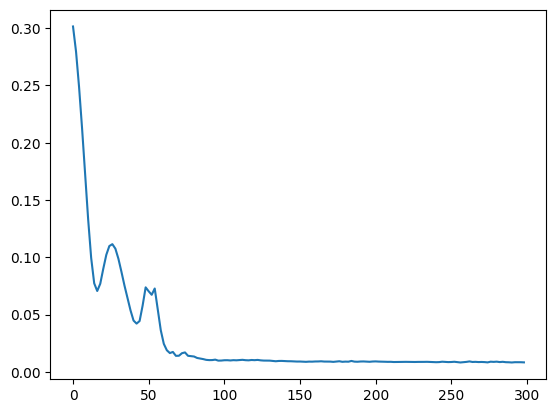

In [ ]:
plt.plot(df['epoch'], df['loss'])
plt.show()